In [1]:
import os

import pkutils as pkutils
from qiba import dce, dsc

import SimpleITK as sitk
import numpy as np

from sklearn.metrics import r2_score
from scipy.optimize import curve_fit, minimize

import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
DCE_DIR = "/home/thulasiseetha/research/dataset/curated/LungMR/dce"
time_arr = np.load("timeArray.npy", allow_pickle=True).item()
stat_df = pd.read_csv("stat_df.csv")
stat_df.head()

,pid,ref_id,age,sex,weight,height,contrast_agent,slice_thickness,voxel_spacing,img_matrix,...,TE,FA,FOV,num_of_phases,acquisition_period,manufacturer,version,field_strength,pdl1>=1%,pdl1>=50%
0,2021064,paz40,067Y,F,49,1.69,DOTAREM,3,"[3.12, 3.12, 3.0]","[128, 128, 32]",...,0.74,25,"[400.0, 400.0, 96.0]",30,1.47,SIEMENS,syngo MR E11,1.5,1,1
1,2565228,paz9,060Y,M,88,1.80,DOTAREM,3,"[3.12, 3.12, 3.0]","[128, 128, 36]",...,0.73,25,"[400.0, 400.0, 108.0]",30,1.54,SIEMENS,syngo MR E11,1.5,0,0
2,2780061,paz3,056Y,M,84,1.75,DOTAREM,3,"[3.12, 3.12, 3.0]","[128, 128, 32]",...,0.74,25,"[400.0, 400.0, 96.0]",30,1.47,SIEMENS,syngo MR E11,1.5,0,0
3,2737310,paz35,070Y,M,82,1.75,DOTAREM,3,"[3.12, 3.12, 3.0]","[128, 128, 36]",...,0.73,25,"[400.0, 400.0, 108.0]",30,1.54,SIEMENS,syngo MR E11,1.5,1,0
4,2776694,paz24,067Y,M,65,1.00,DOTAREM,3,"[3.0, 3.0, 3.0]","[128, 128, 32]",...,0.74,25,"[384.0, 384.0, 96.0]",30,1.47,SIEMENS,syngo MR E11,1.5,0,0


### Selection of on PK Model Configuration among the following choices based on mean R^2
- population AIF = weinmann, parker, georgiou
- tofts model = standard, extended
- bolus arrival estimation methods = linearlinear, linearquadratic, peakgradient

In [4]:
sample_ids = stat_df.ref_id.to_list()

In [5]:
r2_df = {"sample_id":[], "bat_method":[], "aif_fn":[], "pk_model":[], "r2":[]}

aif_methods = {"weinmann":pkutils.weinmann_aif, "parker":pkutils.parker_aif, "georgiou":pkutils.georgiou_aif}
bat_methods = {"ll":pkutils.LinearLinear_BATModel(), "lq":pkutils.LinearQuadratic_BATModel(), "pg":pkutils.PeakGradient_BATModel()}
for sample_id in tqdm(sample_ids, position=0):
    
    row_dict = stat_df[stat_df.ref_id==sample_id].iloc[0].to_dict()

    T1_0 = 1200 * 1e-3  #original in milliseconds https://pubmed.ncbi.nlm.nih.gov/28027756 to seconds

    TR = row_dict["TR"] * 1e-3  # in milliseconds to seconds #not really patient specific, from an arbitrary patient

    FA_deg = row_dict["FA"] #this is not exactly patient specific, value from an arbitrary patient

    r1 = 3.6 #L/mmol/sec

    t_arr = time_arr[sample_id]

    nt = len(t_arr)

    sitk_img = sitk.ReadImage(os.path.join(DCE_DIR, "images", sample_id, "mc_img4D.nii.gz"))
    sitk_tumor_mask = sitk.JoinSeries([sitk.ReadImage(os.path.join(DCE_DIR, "masks", sample_id, "mask.nii.gz"))]*nt)

    img_arr = sitk.GetArrayFromImage(sitk_img)
    tumor_mask_arr = sitk.GetArrayFromImage(sitk_tumor_mask)

    tumor_img_arr = np.ma.array(img_arr, mask=(tumor_mask_arr==0))
    tumor_T1w_t = np.ma.mean(tumor_img_arr, axis=(1,2,3)).data# np.ma.masked_array(img_arr, tumor_mask_arr==0).mean(axis=(1,2,3)).data
    Ct_t = pkutils.T1w_to_Con(tumor_T1w_t, T1_0, TR, FA_deg, r1, 1)
    
    for aif_name, aif_fn in aif_methods.items():
        
        for bat_name, bat_fn in bat_methods.items():
            
            bat_index = bat_fn.run(t_arr, tumor_T1w_t, pkutils.search_interval(tumor_T1w_t)).bat_index

            # delay corrected standard Tofts
            t0_0 = t_arr[bat_index]
            ktrans_0 = 0.058/60 #seconds-1
            ve_0 = 0.2 #fractional volume

            p_init = [t0_0, ktrans_0, ve_0]
            p_lower = (-300.0, 60e-12/60, 0.01)
            p_upper = (300.0, 3/60, 1)

            p_opt, p_cov = curve_fit(pkutils.delayCorrectedStandardTofts(aif_fn), t_arr, Ct_t, p0=p_init, bounds = [p_lower, p_upper], maxfev=100000)#, bounds=bounds)
            standard_t0_opt, standard_ktrans_opt, standard_ve_opt = p_opt
            standard_Ct_t = pkutils.delayCorrectedStandardTofts(aif_fn)(t_arr, *p_opt)
            standard_r2 = r2_score(Ct_t, standard_Ct_t)
            
            r2_df["sample_id"].append(sample_id)
            r2_df["bat_method"].append(bat_name)
            r2_df["aif_fn"].append(aif_name)
            r2_df["pk_model"].append("standard")
            r2_df["r2"].append(standard_r2)
            
            
            # extended
            t0_0 = t_arr[bat_index]
            vp_0 = 0.0025 #fractional volume
            ktrans_0 = 0.058/60 #in seconds
            ve_0 = 0.2 #fractional volume

            p_init = [t0_0, vp_0, ktrans_0, ve_0]
            p_lower = (-300.0, 1e-4, 60e-12/60, 0.01)
            p_upper = (300.0, 1.0, 3/60, 1.0)


            p_opt, p_cov = curve_fit(pkutils.delayCorrectedExtendedTofts(aif_fn), t_arr, Ct_t, p0=p_init, bounds = [p_lower, p_upper], maxfev=100000)#, bounds=bounds)
            extended_t0_opt, extended_vp_opt, extended_ktrans_opt, extended_ve_opt = p_opt
            extended_Ct_t = pkutils.delayCorrectedExtendedTofts(aif_fn)(t_arr, *p_opt)
            extended_r2 = r2_score(Ct_t, extended_Ct_t)
            
            r2_df["sample_id"].append(sample_id)
            r2_df["bat_method"].append(bat_name)
            r2_df["aif_fn"].append(aif_name)
            r2_df["pk_model"].append("extended")
            r2_df["r2"].append(extended_r2)
r2_df = pd.DataFrame(r2_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:49<00:00,  1.29s/it]


In [6]:
r2_df.groupby(by=["pk_model", "aif_fn", "bat_method"]).median()

r2
pk_model aif_fn   bat_method          
extended georgiou ll          0.694062
                  lq          0.653187
                  pg          0.789986
         parker   ll          0.701660
                  lq          0.682349
                  pg          0.788627
         weinmann ll          0.545616
                  lq          0.454448
                  pg          0.527466
standard georgiou ll          0.709552
                  lq          0.660478
                  pg          0.765247
         parker   ll          0.679300
                  lq          0.671148
                  pg          0.682470
         weinmann ll          0.221372
                  lq          0.302506
                  pg          0.065122

<AxesSubplot:>

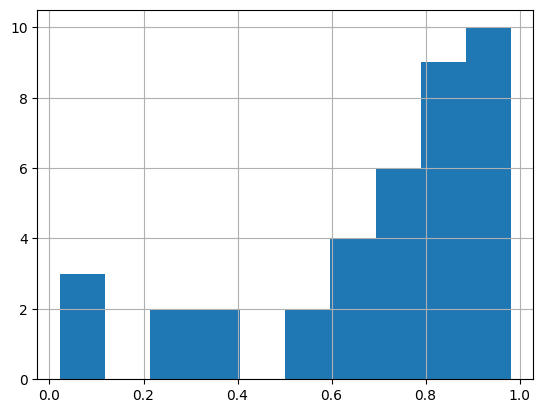

In [7]:
r2_df[(r2_df.pk_model=="extended")&(r2_df.aif_fn=="georgiou")&(r2_df.bat_method=="pg")].r2.hist()